# Simulation Analsysis
In this interactive Notebook the simulation algorithm is analyzed on how many times a match should be sampled for a representative sample of the Poisson-Binomial Distribution. The resulting distribution vectors are assessed over different notions of distance to the exact distribution.

In [1]:
# Import the libraries used in the notebook
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import scipy

In [2]:
xg_df = pd.read_pickle('possession_xGs.pkl')

In [3]:
xg_df.head()

,match_id,possession,team_id,possession_xg
0,7298,4,971,0.018856
1,7298,15,971,0.041846
2,7298,16,971,0.201622
3,7298,41,971,0.118626
4,7298,50,971,0.025282


In [4]:
# This is the DP algorithm which will be used to calculate the exact distribution in a numerically stable way
def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

# This is the simulation algorithm. Apart from the goal probabilities for a posession it also takes in a positive integer n, which is the amount of samples of the match.
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for _ in range(n):
        goal_amnt = sum([int(random.random() < p_i) for p_i in p_is])
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

# This is the function that will be used to calculate the KL divergence between two distributions
def kl_divergence(p, q):
    return sum([p_i*np.log(p_i/q_i) for p_i, q_i in zip(p, q) if q_i > 0])

In [5]:
N = 2000 # Maximum number of simulations
REPEAT = 150 # Number of runs for a single match
cosine_similarities = []
max_abs_diffs = []
avg_abs_diffs = []
jensen_shannon_divergences = []
kl_divergences = []
number_of_xgs = []
for i in tqdm(range(1, N+1)):
    chosen_match = np.random.choice(xg_df['match_id'].unique())
    chosen_team = np.random.choice(xg_df[xg_df['match_id'] == chosen_match]['team_id'].unique())
    p_is = xg_df[(xg_df['match_id'] == chosen_match) & (xg_df['team_id'] == chosen_team)]['possession_xg'].to_list()
    number_of_xgs.append(len(p_is))
    exact_distribution = np.array(dp(p_is))
    simulated_distributions = []
    for _ in range(REPEAT):
        simulated_distributions.append(np.array(simulation(p_is, i)))
    cos_agg = np.zeros(REPEAT)
    max_abs_agg = np.zeros(REPEAT)
    avg_abs_diffs_agg = np.zeros(REPEAT)
    jens_shan_agg = np.zeros(REPEAT)
    kldiv_agg = np.zeros(REPEAT)
    for i, sim_distribution in enumerate(simulated_distributions):
        cos_agg[i] = scipy.spatial.distance.cosine(exact_distribution, sim_distribution)
        max_abs_agg[i] = np.max(np.absolute(exact_distribution - sim_distribution))
        jens_shan_agg[i] = scipy.spatial.distance.jensenshannon(exact_distribution, sim_distribution)
        kldiv_agg[i] = kl_divergence(exact_distribution, sim_distribution)
        avg_abs_diffs_agg[i] = np.average(np.absolute(np.array(sim_distribution) - exact_distribution))
    kl_divergences.append(np.average(kldiv_agg))
    cosine_similarities.append(np.average(cos_agg))
    max_abs_diffs.append(np.average(max_abs_agg))
    jensen_shannon_divergences.append(np.average(jens_shan_agg))
    avg_abs_diffs.append(np.average(avg_abs_diffs_agg))

100%|██████████| 2000/2000 [08:12<00:00,  4.06it/s]


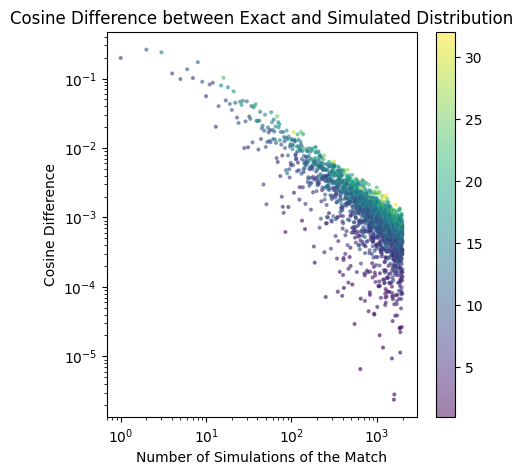

In [6]:
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), cosine_similarities, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Cosine Difference between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Cosine Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

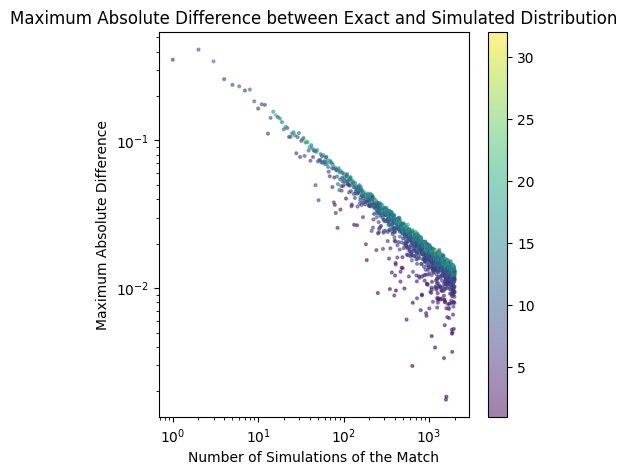

In [7]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), max_abs_diffs, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Maximum Absolute Difference between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Maximum Absolute Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

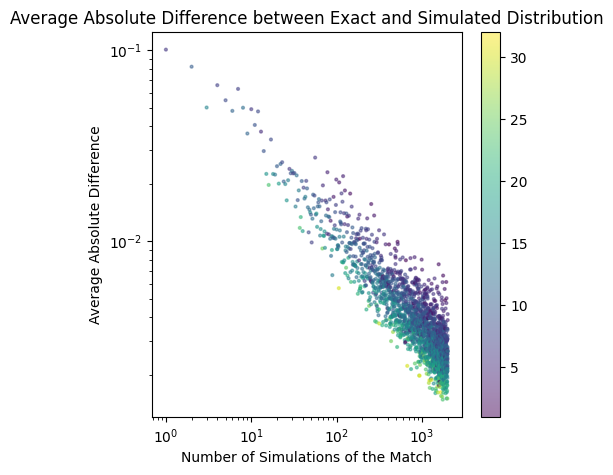

In [8]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), avg_abs_diffs, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Average Absolute Difference between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Average Absolute Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

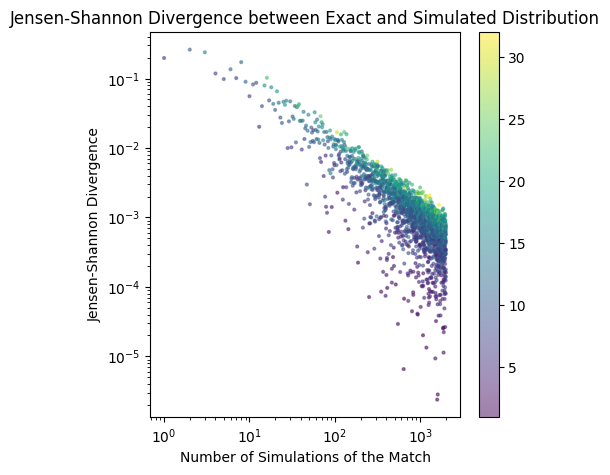

In [9]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), cosine_similarities, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Jensen-Shannon Divergence between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Jensen-Shannon Divergence')
plt.show()

<Figure size 640x480 with 0 Axes>

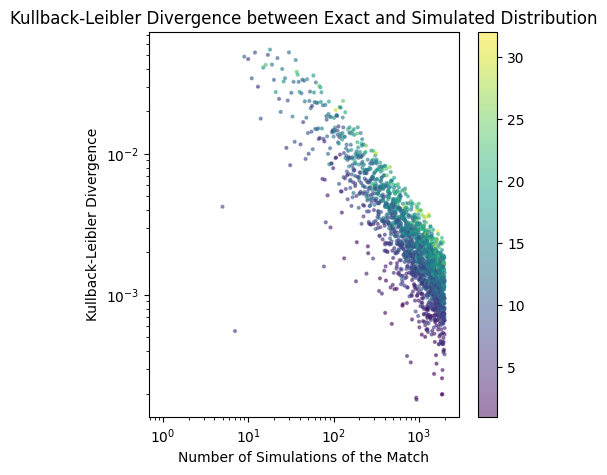

In [10]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(range(1, N+1), kl_divergences, c=number_of_xgs, s=4, alpha=0.5)
plt.colorbar()
plt.title('Kullback-Leibler Divergence between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Kullback-Leibler Divergence')
plt.show()

It appears that matches with a higher number of Possession xGs per team are usually more subject to the effect of the simulated distribution to diverge from the exact distribution. This is what one might expect, since there are more entries in the distribution vector to be filled. Let's analyze the case of the match with the highest shotcount deeper.

In [11]:
# Get the Possession xGs of the match with the highest shot count
max_xg_count_grouping = xg_df.groupby('match_id').apply(lambda df: df.groupby('team_id')['team_id'].count())
print(f'Maximum number of Possession xGs per team and match is {max_xg_count_grouping.max()}')
match_id, team_id = max_xg_count_grouping[max_xg_count_grouping == max_xg_count_grouping.max()].index[0]
print(f'This happened in match {match_id} and was achieved by team {team_id}')
p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()

Maximum number of Possession xGs per team and match is 43
This happened in match 18237 and was achieved by team 169


This time we don't average over the evaluation metrics, as in applied scenarios we only run the simulation once.

In [12]:
# Now run the simulation analysis again on this match
N = 10000 # Maximum number of simulations
cosine_similarities = []
max_abs_diffs = []
std_abs_diffs = []
jensen_shannon_divergences = []
kl_divergences = []
number_of_xgs = [len(p_is)] * N
for i in tqdm(range(1, N+1)):
    number_of_xgs.append(len(p_is))
    exact_distribution = np.array(dp(p_is))
    simulated_distribution = np.array(simulation(p_is, i))
    cosine_similarities.append(scipy.spatial.distance.cosine(exact_distribution, simulated_distribution))
    max_abs_diffs.append(np.max(np.absolute(exact_distribution - simulated_distribution)))
    std_abs_diffs.append(np.std(simulated_distribution - exact_distribution))
    jensen_shannon_divergences.append(scipy.spatial.distance.jensenshannon(exact_distribution, simulated_distribution))
    kl_divergences.append(kl_divergence(exact_distribution, simulated_distribution))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [04:17<00:00, 38.91it/s]


<Figure size 640x480 with 0 Axes>

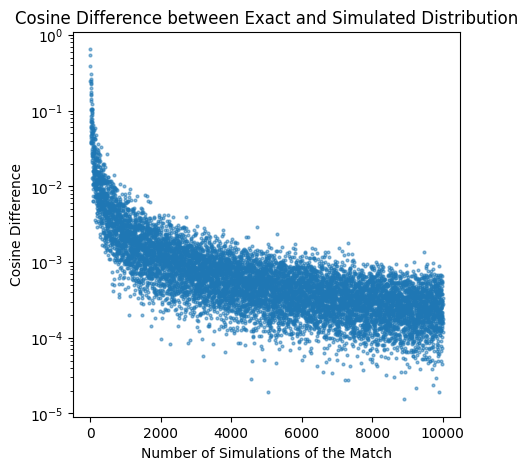

In [13]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.scatter(range(1, N+1), cosine_similarities, s=4, alpha=0.5)
plt.title('Cosine Difference between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Cosine Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

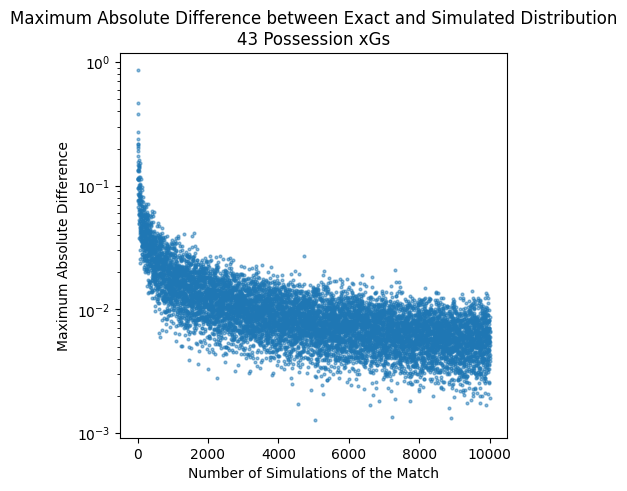

In [14]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.scatter(range(1, N+1), max_abs_diffs, s=4, alpha=0.5)
plt.title('Maximum Absolute Difference between Exact and Simulated Distribution\n43 Possession xGs')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Maximum Absolute Difference')
plt.show()

<Figure size 640x480 with 0 Axes>

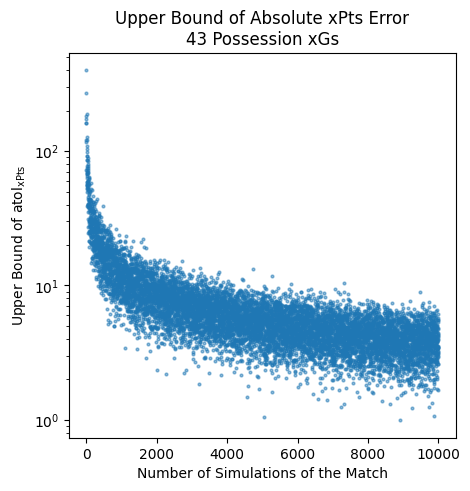

In [15]:
N_H = 43
atol_xpts_upbound = lambda atol_entry: 3 * (N_H**2 + N_H)/2 * atol_entry
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.scatter(range(1, N+1), [atol_xpts_upbound(std_abs_diff) for std_abs_diff in std_abs_diffs], s=4, alpha=0.5)
plt.title('Upper Bound of Absolute xPts Error\n43 Possession xGs')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel(r'Upper Bound of atol$_\text{xPts}$')
plt.show()

<Figure size 640x480 with 0 Axes>

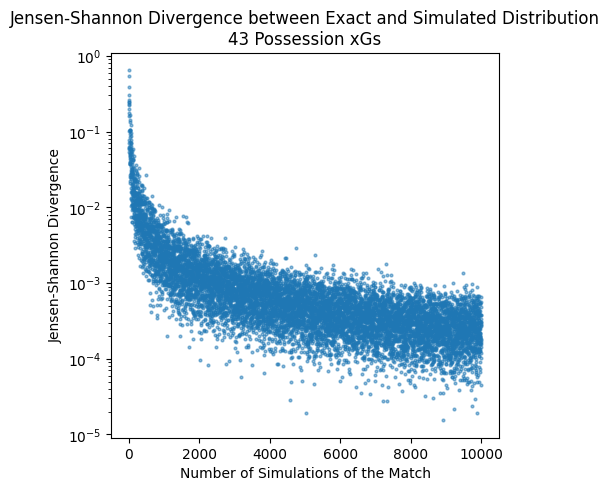

In [16]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.scatter(range(1, N+1), cosine_similarities, s=4, alpha=0.5)
plt.title('Jensen-Shannon Divergence between Exact and Simulated Distribution\n43 Possession xGs')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Jensen-Shannon Divergence')
plt.show()

<Figure size 640x480 with 0 Axes>

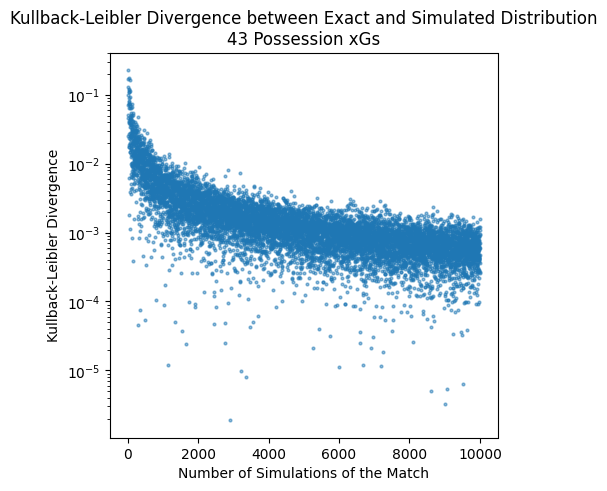

In [17]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.scatter(range(1, N+1), kl_divergences, s=4, alpha=0.5)
plt.title('Kullback-Leibler Divergence between Exact and Simulated Distribution\n43 Possession xGs')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Kullback-Leibler Divergence')
plt.show()

It's also helpful to see how the distribution of the errors behave. Let's plot this distribution for N = 1000 and still the same match with 43 Possession xGs.

In [18]:
# Now run the simulation analysis again on this match
N = 1000 # Maximum number of simulations
errors = []
for i in tqdm(range(1, N+1)):
    exact_distribution = np.array(dp(p_is))
    simulated_distribution = np.array(simulation(p_is, N))
    errors.append(exact_distribution - simulated_distribution)
errors = np.concatenate(errors)
print(errors.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 191.48it/s]

(44000,)


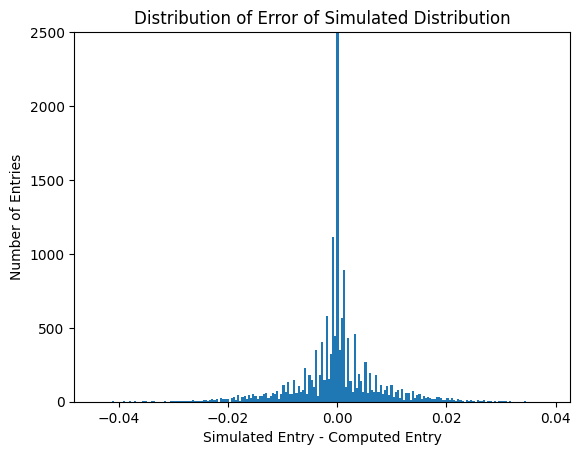

0.0044275772105287535


In [19]:
plt.clf()
plt.hist(errors, bins=int(np.sqrt(len(errors))))
plt.title('Distribution of Error of Simulated Distribution')
plt.xlabel('Simulated Entry - Computed Entry')
plt.ylabel('Number of Entries')
plt.ylim(0, 2500)
plt.show()
print(np.std(errors))

In [20]:
# The formula to calculate the xPts of the home team
def xpts(home_pis, away_pis):
    draw_prob = 0
    winning_prob = 0
    # Match outcome is a draw
    for i in range(min(len(home_pis), len(away_pis))):
        draw_prob += home_pis[i] * away_pis[i]
    # Match outcome is a win
    for i, home_pi in enumerate(home_pis):
        for j in range(min(i, len(away_pis))):
            winning_prob += home_pi * away_pis[j]
    return draw_prob + 3 * winning_prob

In [23]:
# Now run the simulation analysis again on this match
N = 10000 # Maximum number of simulations
xpts_abs_errors = []
for i in tqdm(range(1, N+1)):
    match_id = xg_df.sample()['match_id'].iat[0]
    match_select = xg_df['match_id'] == match_id
    home_team = xg_df[match_select].sample()['team_id'].iat[0]
    home_team_select = xg_df['team_id'] == home_team
    home_pis = xg_df[match_select & home_team_select]['possession_xg'].to_list()
    away_pis = xg_df[match_select & ~home_team_select]['possession_xg'].to_list()
    exact_xpts = xpts(dp(home_pis), dp(away_pis))
    sim_xpts = xpts(simulation(home_pis, i), simulation(away_pis, i))
    xpts_abs_errors.append(np.absolute(sim_xpts - exact_xpts))

100%|██████████| 10000/10000 [03:06<00:00, 53.74it/s]


<Figure size 640x480 with 0 Axes>

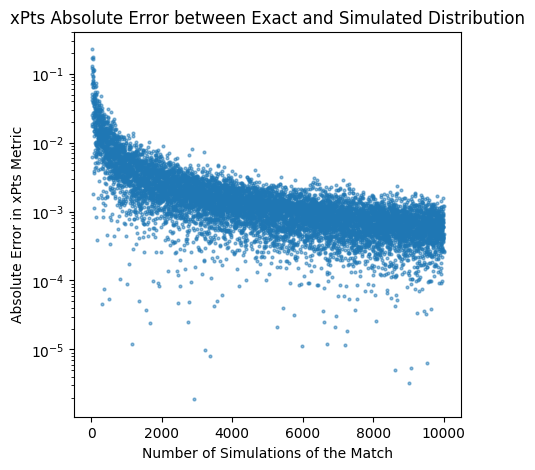

In [25]:
plt.clf()
plt.figure(figsize=(5, 5))
plt.yscale('log')
plt.scatter(range(1, N+1), kl_divergences, s=4, alpha=0.5)
plt.title('xPts Absolute Error between Exact and Simulated Distribution')
plt.xlabel('Number of Simulations of the Match')
plt.ylabel('Absolute Error in xPts Metric')
plt.show()